# **ZSG EDA**

The goal of this notebook will be to (1) validate the output of the ZSG (zero sum game) results and (2) evaluate their added value.

First, we will validate by making sure the win probabilities are similar to those of the non-strategic policy evaluation. It will also be interesting to see whether the ZSG optimization benefits the weaker or stronger player more.

Second, we will examine how much the optimal policy changes using the optimal ZSG approach.

# 1.0 Notebook Parameters

Please specify the following variables:
1. `project_directory`: your project directory path
2. `epsilon_list`: the list of execution error multiplers (epsilon) that you want to consider in your analysis.
3. `epsilon_list_extremes`: the list of *high* execution error multiplers (epsilon) that you want to consider in your analysis.

In [2]:
# Change this to the project directory path for your computer  
project_directory = '/Users/rachael/Desktop/darts-thesis'

# Set the epsilons that will be considered in this analysis 
epsilon_list = [1,2,3,4,5,6,7,8,9]

# 2.0 Notebook Setup

Import libraries and run helper functions.

In [3]:
# Import and configure modules from this project

import os

os.chdir(project_directory)

import function_tool as ft
import function_init_simple_mdp as imdp
import function_plot_board as ib

In [4]:
# Import and configure external modules

import pandas as pd

import seaborn as  sns 
import matplotlib.pyplot as plt
from matplotlib import cm, colors
#sns.set_theme()   # uncomment this if you want seasborn theme

import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=300)
np.set_printoptions(threshold=300)

import scipy.io as sio
from scipy.stats import multivariate_normal

In [88]:
# Helper function

# Color mapping function
def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = colors.rgb2hex(rgb)
    return color

# Linear interpolation function
def linear_interpolation(x1,x2,y1,y2,y):
    x = x1 - ((y1-y)/(y1-y2))*(x1-x2)


# KDE plot creator
def createKde(data, x, y, title="", ax=None, cmap='Blues', levels=10, alpha=1):
    if ax == None:
        ax = plt.gca()
    sns.kdeplot(data=data, x=x, y=y, cmap=cmap, fill=True, levels=levels, ax=ax, alpha=alpha)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ib.plot_basic_board(axes=ax)
    ax.title.set_text(title)


# Get player's gaussian distribution 
def get_gaussian(x_val,y_val,error_multiplier,player_index=7):
  
  result_dir = fb.data_parameter_dir + '/grid_full'
  if not os.path.isdir(result_dir):
      os.makedirs(result_dir)
  player_parameter = sio.loadmat('./data_parameter/ALL_Model_Fits.mat')
  
  ## 1mm-width grid of 341*341 aiming locations (a sqaure enclosing the circle dart board)
  [xindex, yindex, xgrid, ygrid, grid_num] = fb.get_1mm_grid()

  xi = np.where(xgrid==x_val)[0][0]
  yi = np.where(xgrid==y_val)[0][0]

  ## select the proper Gaussian distribution according to the area to which the aiming location belongs
  mu = [xgrid[xi], ygrid[yi]]
  score, multiplier = fb.get_score_and_multiplier(mu)
  if (score==60 and multiplier==3): ##triple 20
      covariance_matrix = player_parameter['ModelFit_T20'][0, player_index][2] * error_multiplier
  elif (score==57 and multiplier==3): ##triple 19
      covariance_matrix = player_parameter['ModelFit_T19'][0, player_index][2] * error_multiplier
  elif (score==54 and multiplier==3): ##triple 18
      covariance_matrix = player_parameter['ModelFit_T18'][0, player_index][2] * error_multiplier
  elif (score==51 and multiplier==3): ##triple 17
      covariance_matrix = player_parameter['ModelFit_T17'][0, player_index][2] * error_multiplier
  elif (score==50 and multiplier==2): ##double bull
      covariance_matrix = player_parameter['ModelFit_B50'][0, player_index][2] * error_multiplier
  else:
      covariance_matrix = player_parameter['ModelFit_All_Doubles'][0, player_index][2] * error_multiplier
  
  return mu,covariance_matrix


# Plot gaussian dsitribution 
def plot_gaussian(x_val,y_val,error_multiplier,player_index=7,xlim=(-200,200),ylim=(-200,200),figsize = (8,8),ax=None,title=''):
  
  mu,covariance_matrix = get_gaussian(x_val,y_val,error_multiplier,player_index=player_index)
  rv = multivariate_normal(mu, covariance_matrix)
  
  x, y = np.mgrid[-200:200:1, -200:200:1]
  pos = np.dstack((x, y))
  
  axes = ib.plot_basic_board(xlim=xlim,ylim=ylim,figsize = figsize,axes=ax)

  ax.title.set_text(title)
  
  fi = axes.contourf(x, y, rv.pdf(pos), 20, cmap='Greens')

# Helper function to deconstruct the solved MDPs and reformat as a dataframe 
def create_policy_dataframe(policy_dictionary,zsg=True):
    
    
    df_list = []

    if (zsg):  
        col_names = ['tokens','score_weaker','score_stronger','remaining_throws','score_gained','optimal_policy']  
        for sw in  policy_dictionary.keys():
            for ss in  policy_dictionary.keys():
                for rt in range(1,4):
                    for t in range(0,policy_dictionary[sw][ss][rt].shape[0]):
                        for u in range(0,policy_dictionary[sw][ss][rt].shape[1]):
                            optimal_policy = policy_dictionary[ss][ss][rt][t][u]
                            if optimal_policy == -1:
                                continue
                            else:
                                df_list.append([t,sw,ss,rt,u,optimal_policy])

    else:
        col_names = ['tokens','score','remaining_throws','score_gained','optimal_policy']
        for s in  policy_dictionary.keys():
            for rt in range(1,4):
                for t in range(0,policy_dictionary[s][rt].shape[0]):
                    for u in range(0,policy_dictionary[s][rt].shape[1]):
                        optimal_policy = policy_dictionary[s][rt][t][u]
                        if optimal_policy == -1:
                            continue
                        else:
                            df_list.append([t,s,rt,u,optimal_policy])

    df = pd.DataFrame(df_list,columns=col_names)
    a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
    df['optimal_policy_name'] = df['optimal_policy'].map(a_map)
        
    return df 



# 2.0 Win Probability Validation

## 2.1 Numerical Validation

This section will compare $\epsilon=1$ vs $\epsilon=2$.

### 2.1.1 Load Data

In [7]:
# Get the value function dictionary for the zero sum game 
zsg_e1e2_value = ft.load_pickle('result/twoplayer_zsg_results/zsg_value_W_player10e2_S_player10e1__optboth.pkl')

In [8]:
# Get the value functions for when the weaker and stronger players are starting
zsg_e1e2value_pw = zsg_e1e2_value['value_pw']
zsg_e1e2value_ps = zsg_e1e2_value['value_ps']

In [9]:
# Get the value function dictionary for the weaker player's best response
br_e1e2_value = ft.load_pickle('result/twoplayer_br_results/zsg_value_W_player10e2_S_player10e1__optW.pkl')

In [10]:
# Get the value functions for when the weaker and stronger players are starting
br_e1e2value_pw = br_e1e2_value['value_pw']
br_e1e2value_ps = br_e1e2_value['value_ps']

In [11]:
# Get the non-strategic win probability evaluation
df_ns_win_probs = pd.read_csv('result/twoplayer_ns_results/player10_win_probability_results_stronger_e1.csv')

In [12]:
# Get the win probabilities for specific non-strategic matchup
df_ns_win_probs_e1e2 = df_ns_win_probs.loc[(df_ns_win_probs.epsilon_weaker==2) & (df_ns_win_probs.epsilon_stronger==1)]

The values printed out below correspond to the probability the weaker player wins given that it is the weaker player's turn at the starting state. The values are printed out for each policy to be compared.

### 2.1.2 Run Test Cases

In [13]:
# Test Cases

print("-----------------------------------------------------------------------------------------------")
# 2 vs 2
print("Case 3: weaker 2 vs. stronger 2")
ns_val = df_ns_win_probs_e1e2[(df_ns_win_probs_e1e2.score_weaker==2) & (df_ns_win_probs_e1e2.score_stronger==2) & (df_ns_win_probs_e1e2.current_turn=='weaker')].win_probability_weaker.values
print(f"ZSG Values: {zsg_e1e2value_pw[:,2,2]}")
print(f"BR Values: {br_e1e2value_pw[:,2,2]}")
print(f"NonStrategic Values: {ns_val}")

print("-----------------------------------------------------------------------------------------------")
# 7 vs 7
print("Case 3: weaker 7 vs. stronger 7")
ns_val = df_ns_win_probs_e1e2[(df_ns_win_probs_e1e2.score_weaker==7) & (df_ns_win_probs_e1e2.score_stronger==7) & (df_ns_win_probs_e1e2.current_turn=='weaker')].win_probability_weaker.values
print(f"ZSG Values: {zsg_e1e2value_pw[:,7,7]}")
print(f"BR Values: {br_e1e2value_pw[:,7,7]}")
print(f"NonStrategic Values: {ns_val}")

print("-----------------------------------------------------------------------------------------------")
# 100 vs 100
print("Case 3: weaker 42 vs. stronger 51")
ns_val = df_ns_win_probs_e1e2[(df_ns_win_probs_e1e2.score_weaker==75) & (df_ns_win_probs_e1e2.score_stronger==100) & (df_ns_win_probs_e1e2.current_turn=='weaker')].win_probability_weaker.values
print(f"ZSG Values: {zsg_e1e2value_pw[:,15,23]}")
print(f"BR Values: {br_e1e2value_pw[:,15,23]}")
print(f"NonStrategic Values: {ns_val}")

print("-----------------------------------------------------------------------------------------------")
# 100 vs 75
print("Case 3: weaker 51 vs. stronger 42")
ns_val = df_ns_win_probs_e1e2[(df_ns_win_probs_e1e2.score_weaker==100) & (df_ns_win_probs_e1e2.score_stronger==75) & (df_ns_win_probs_e1e2.current_turn=='weaker')].win_probability_weaker.values
print(f"ZSG Values: {zsg_e1e2value_pw[:,23,15]}")
print(f"BR Values: {br_e1e2value_pw[:,23,15]}")
print(f"NonStrategic Values: {ns_val}")

print("-----------------------------------------------------------------------------------------------")
# 75 vs 75
print("Case 3: stronger 51 vs. weaker 51")
ns_val = df_ns_win_probs_e1e2[(df_ns_win_probs_e1e2.score_weaker==75) & (df_ns_win_probs_e1e2.score_stronger==75) & (df_ns_win_probs_e1e2.current_turn=='weaker')].win_probability_weaker.values
print(f"ZSG Values: {zsg_e1e2value_pw[:,23,23]}")
print(f"BR Values: {br_e1e2value_pw[:,23,23]}")
print(f"NonStrategic Values: {ns_val}")

-----------------------------------------------------------------------------------------------
Case 3: weaker 2 vs. stronger 2
ZSG Values: [0.5509 1.     1.     1.     1.     1.     1.     1.     1.     1.    ]
BR Values: [0.5509 1.     1.     1.     1.     1.     1.     1.     1.     1.    ]
NonStrategic Values: [0.5509 1.     1.     1.     1.     1.     1.     1.     1.     1.    ]
-----------------------------------------------------------------------------------------------
Case 3: weaker 7 vs. stronger 7
ZSG Values: [0.5621 0.9688 1.     1.     1.     1.     1.     1.     1.     1.    ]
BR Values: [0.5615 0.9693 1.     1.     1.     1.     1.     1.     1.     1.    ]
NonStrategic Values: [0.5591 0.9693 1.     1.     1.     1.     1.     1.     1.     1.    ]
-----------------------------------------------------------------------------------------------
Case 3: weaker 42 vs. stronger 51
ZSG Values: [0.5763 0.9801 1.     1.     1.     1.     1.     1.     1.     1.    ]
BR Values:

### 2.1.3 Test Case Sandbox

In [14]:
################## PARAMETERS ##################

score_weak = 24
score_strong = 24

################################################

# Get the values for non-strategic 
ns_val_w = df_ns_win_probs_e1e2[(df_ns_win_probs_e1e2.score_weaker==score_weak) & (df_ns_win_probs_e1e2.score_stronger==score_strong) & (df_ns_win_probs_e1e2.current_turn=='weaker')].win_probability_weaker.values
ns_val_s = df_ns_win_probs_e1e2[(df_ns_win_probs_e1e2.score_weaker==score_weak) & (df_ns_win_probs_e1e2.score_stronger==score_strong) & (df_ns_win_probs_e1e2.current_turn=='stronger')].win_probability_weaker.values

# Get the values for zero sum game (zsg)
zsg_val_w = zsg_e1e2value_pw[:,score_weak,score_strong]
zsg_val_s = zsg_e1e2value_ps[:,score_weak,score_strong]

# Get the values for best response (br)
br_val_w = br_e1e2value_pw[:,score_weak,score_strong]
br_val_s = br_e1e2value_ps[:,score_weak,score_strong]

print('-----------------------------------------------')
print('When weaker player is starting ')
print('\tNon-strategic win probability:',ns_val_w.round(3))
print('\tBR win probability:',br_val_w.round(3))
print('\tZSG win probability:',zsg_val_w.round(3))
print('-----------------------------------------------')
print('When stronger player is starting ')
print('\tNon-strategic win probability:',ns_val_s.round(3))
print('\tBR win probability:',br_val_s.round(3))
print('\tZSG win probability:',zsg_val_s.round(3))
print('-----------------------------------------------')
print('Average ')
print('\tNon-strategic win probability:',((ns_val_s + ns_val_w)/2).round(3))
print('\tBR win probability:',((br_val_w + br_val_s)/2).round(3))
print('\tZSG win probability:',((zsg_val_w + zsg_val_s)/2).round(3))


-----------------------------------------------
When weaker player is starting 
	Non-strategic win probability: [0.671 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
	BR win probability: [0.691 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
	ZSG win probability: [0.704 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
-----------------------------------------------
When stronger player is starting 
	Non-strategic win probability: [0.129 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185]
	BR win probability: [0.132 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185]
	ZSG win probability: [0.13  0.182 0.182 0.182 0.182 0.182 0.182 0.182 0.182 0.182]
-----------------------------------------------
Average 
	Non-strategic win probability: [0.4   0.593 0.593 0.593 0.593 0.593 0.593 0.593 0.593 0.593]
	BR win probability: [0.412 0.593 0.593 0.593 0.593 0.593 0.593 0.593 0.593 0.593]
	ZSG win probability: [0.417 0.591 0.591 0.591 0.591 0.591 0.591 0.591 0.591 0.591

## 2.2 Compare Value Function for Different Tokens

In [15]:
############ SET PARAMETERS HERE ###########

# Starting score of the game 
# In a normal game, this would be 501, but can use a lower value if needed 
starting_score = 24

# Epsilon of stronger player that you want to use for graphing 
stronger_epsilon = 1

# List of epsilons - will automatically select only the weaker ones
epsilon_list = [1,2,3,4,5,6,7,8,9]

############################################

### 2.2.1 Non-Strategic (NS) Results

In this case, players use their self-optimized policies which do not consider their oponent at all.

In [18]:
# Load csv
df_ns = pd.read_csv('result/twoplayer_ns_results/player10_win_probability_results.csv')
df_ns = df_ns[['epsilon_weaker', 'epsilon_stronger', 'score_weaker','score_stronger', 'credits_weaker', 'current_turn',
       'win_probability_weaker']]


In [19]:

# Get data for specified stronger player
dfe_ns = df_ns.loc[df_ns.epsilon_stronger==stronger_epsilon]

# Get data for when both players are at the start of the game
df_ns_start_special = dfe_ns.loc[(dfe_ns.score_weaker==starting_score) & (dfe_ns.score_stronger==starting_score)]

# Get data for when weaker and stronger player are starting, respectively 
# df_ns_start_weaker_special = df_ns_start_special.loc[df_ns_start_special.current_turn=='weaker']
# df_ns_start_stronger_special = df_ns_start_special.loc[df_ns_start_special.current_turn=='stronger']

# Get data for averaged case across starters 
df_ns_start_avg_special = df_ns_start_special.groupby(['epsilon_weaker', 'epsilon_stronger', 'score_weaker','score_stronger', 'credits_weaker']).mean()
df_ns_start_avg_special = df_ns_start_avg_special.reset_index()

/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_42378/980313793.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ns_start_avg_special = df_ns_start_special.groupby(['epsilon_weaker', 'epsilon_stronger', 'score_weaker','score_stronger', 'credits_weaker']).mean()


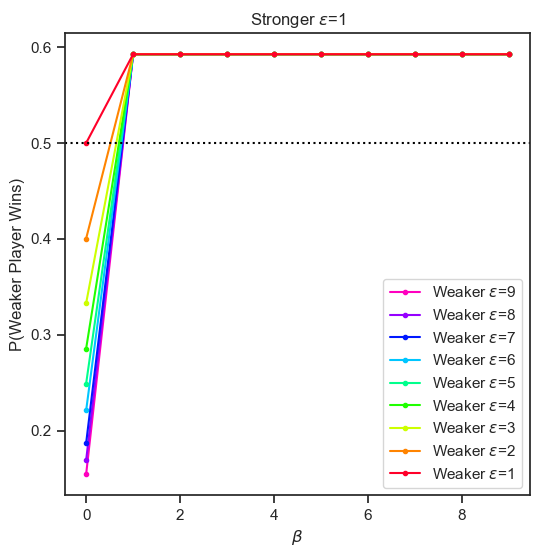

In [21]:
epsilon_color_list = [1,2,3,4,5,6,7,8,9]

e_leg = []
vmax=max(epsilon_color_list)
vmin=min(epsilon_color_list)

fig = sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks")

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon=epsilon_list[e]
    dfew_ns = df_ns_start_avg_special.loc[df_ns_start_avg_special.epsilon_weaker==epsilon]
    dfew_ns = dfew_ns[['credits_weaker','win_probability_weaker']]    
    dfew_ns = dfew_ns.set_index('credits_weaker')
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon))
    fig = plt.plot(dfew_ns,marker ='.',color=color)

fig = plt.title(fr'Stronger $\epsilon$={epsilon}')
fig = plt.xlabel(r'$\beta$')
fig = plt.ylabel(r'P(Weaker Player Wins)')
fig = plt.legend(e_leg)

# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted') 


### 2.2.2 Best Response (BR) Results

In this case, the weaker player is optimizing their best response against the stronger player, who is not optimizing (playing their non-strategic policy).

In [22]:
# Retreive data from solved BRs and store in a dataframe 

df_list_br = []
columns = ['stronger_epsilon','weaker_epsilon','weaker_tokens','starting_score','prob_weaker_wins_weaker_starts','prob_weaker_wins_stronger_starts','prob_weaker_wins_avg']

# Iterate through tokens 
for token in range(0,10):

    # Iterate through weaker epsilons 
    for weaker_epsilon in epsilon_list:

        # Check that it's weaker than stronger_epsilon specified above
        if weaker_epsilon >= stronger_epsilon: 
        
            # Get relevant filename with solved br value function for this pair
            filename = f'result/twoplayer_br_results/zsg_value_W_player10e{weaker_epsilon}_S_player10e{stronger_epsilon}__optW.pkl'

            # Load the win probability values  
            res_values = ft.load_pickle(filename)

            # Save the win probabilities of the weaker player for the two starting combinations, plus the average
            value_weaker_starting = res_values['value_pw'][token,starting_score,starting_score]
            value_stronger_starting = res_values['value_ps'][token,starting_score,starting_score]
            value_average = (value_weaker_starting + value_stronger_starting) / 2

            # Store in dataframe list
            df_list_br.append([stronger_epsilon,weaker_epsilon,token,starting_score,value_weaker_starting,value_stronger_starting,value_average])
            
            # Delete loaded value functions to clear memory 
            del res_values

# Save in a dataframe 
df_br = pd.DataFrame(data=df_list_br,columns=columns)


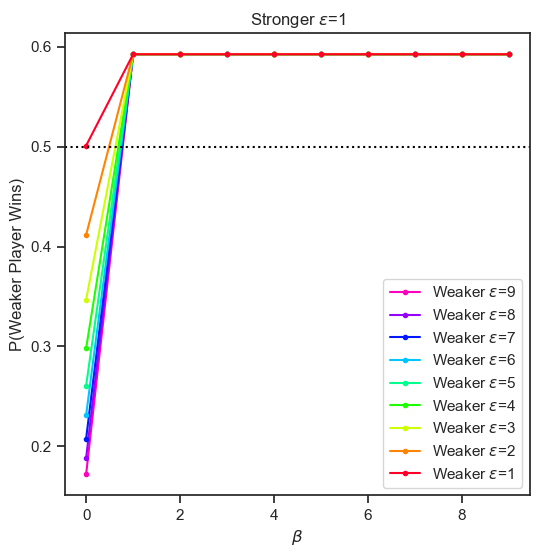

In [23]:
# Plot Graph  

# Housekeeping 
e_leg = [] # Create a placeholder list for legend 
epsilon_color_list = [1,2,3,4,5,6,7,8,9] # keep epsilon colors consistent, regardless of what's being analyzed 
vmax=max(epsilon_color_list) # Set max epsilon for color scale
vmin=min(epsilon_color_list) # Set min epsilon for color scale

# Set figure size
fig = sns.set(rc={'figure.figsize':(6,6)})

# Set figure theme to matplotlib default
sns.set_theme(style="ticks")

# Plot line for each epsilon value 
for e in reversed(range(len(epsilon_list))):
    epsilon=epsilon_list[e] # get epislon value
    dfew_br = df_br.loc[df_br.weaker_epsilon==epsilon] # get data for that epsilon 
    dfew_br = dfew_br[['weaker_tokens','prob_weaker_wins_avg']] # grab columns we want
    dfew_br = dfew_br.set_index('weaker_tokens') # set index to tokens
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax) # get the color for current epsilon
    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon)) # add to legend
    fig = plt.plot(dfew_br,marker ='.',color=color) # plot the line graph with markers


# Legend, title, and axis labels
fig = plt.legend(e_leg) # plot legend 
fig = plt.title(fr'Stronger $\epsilon$={epsilon}')
fig = plt.xlabel(r'$\beta$')
fig = plt.ylabel(r'P(Weaker Player Wins)')


# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted')


### 2.2.3 Zero Sum Game (ZSG)

In this case, both players are optimizing their policies and are using the equillibrium policy generated by the ZSG formulation.

In [24]:
# Retreive data from solved ZSGs and store in a dataframe 

df_list_zsg = []
columns = ['stronger_epsilon','weaker_epsilon','weaker_tokens','starting_score','prob_weaker_wins_weaker_starts','prob_weaker_wins_stronger_starts','prob_weaker_wins_avg']

# Iterate through tokens 
for token in range(0,10):

    # Iterate through weaker epsilons 
    for weaker_epsilon in epsilon_list:

        # Check that it's weaker than stronger_epsilon specified above
        if weaker_epsilon >= stronger_epsilon: 
        
            # Get relevant filename with solved ZSG value function for this pair
            filename = f'result/twoplayer_zsg_results//zsg_value_W_player10e{weaker_epsilon}_S_player10e{stronger_epsilon}__optboth.pkl'

            # Load the win probability values  
            res_values = ft.load_pickle(filename)

            # Save the win probabilities of the weaker player for the two starting combinations, plus the average
            value_weaker_starting = res_values['value_pw'][token,starting_score,starting_score]
            value_stronger_starting = res_values['value_ps'][token,starting_score,starting_score]
            value_average = (value_weaker_starting + value_stronger_starting) / 2

            # Store in dataframe list
            df_list_zsg.append([stronger_epsilon,weaker_epsilon,token,starting_score,value_weaker_starting,value_stronger_starting,value_average])
            
            # Delete loaded value functions to clear memory 
            del res_values

# Save in a dataframe 
df_zsg = pd.DataFrame(data=df_list_zsg,columns=columns)


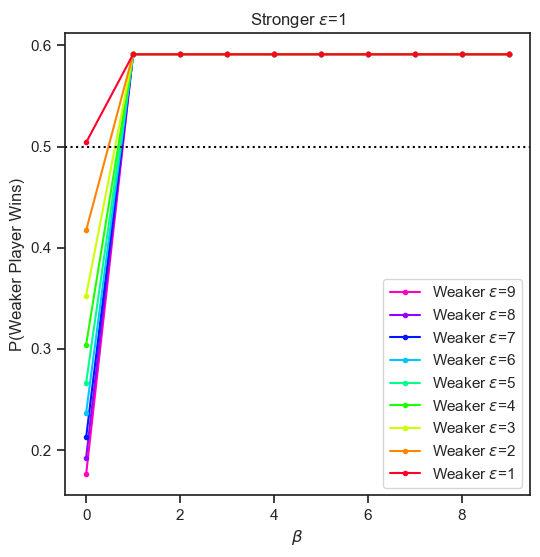

In [25]:
# Plot Graph  

# Housekeeping 
e_leg = [] # Create a placeholder list for legend 
epsilon_color_list = [1,2,3,4,5,6,7,8,9] # keep epsilon colors consistent, regardless of what's being analyzed 
vmax=max(epsilon_color_list) # Set max epsilon for color scale
vmin=min(epsilon_color_list) # Set min epsilon for color scale

# Set figure size
fig = sns.set(rc={'figure.figsize':(6,6)})

# Set figure theme to matplotlib default
sns.set_theme(style="ticks")

# Plot line for each epsilon value 
for e in reversed(range(len(epsilon_list))):
    epsilon=epsilon_list[e] # get epislon value
    dfew_zsg = df_zsg.loc[df_zsg.weaker_epsilon==epsilon] # get data for that epsilon 
    dfew_zsg = dfew_zsg[['weaker_tokens','prob_weaker_wins_avg']] # grab columns we want
    dfew_zsg = dfew_zsg.set_index('weaker_tokens') # set index to tokens
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax) # get the color for current epsilon
    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon)) # add to legend
    fig = plt.plot(dfew_zsg,marker ='.',color=color) # plot the line graph with markers


# Legend, title, and axis labels
fig = plt.legend(e_leg) # plot legend 
fig = plt.title(fr'Stronger $\epsilon$={epsilon}')
fig = plt.xlabel(r'$\beta$')
fig = plt.ylabel(r'P(Weaker Player Wins)')


# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted')


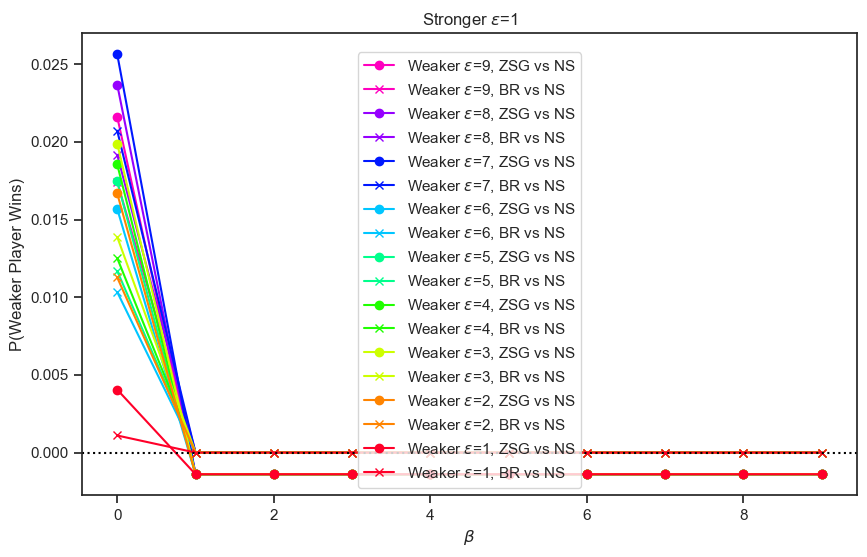

In [56]:
# Plot Graph  

# Housekeeping 
e_leg = [] # Create a placeholder list for legend 
epsilon_color_list = [1,2,3,4,5,6,7,8,9] # keep epsilon colors consistent, regardless of what's being analyzed 
vmax=max(epsilon_color_list) # Set max epsilon for color scale
vmin=min(epsilon_color_list) # Set min epsilon for color scale

# Set figure size
fig = sns.set(rc={'figure.figsize':(10,6)})

# Set figure theme to matplotlib default
sns.set_theme(style="ticks")

# Plot line for each epsilon value 
for e in reversed(range(len(epsilon_list))):
    epsilon=epsilon_list[e] # get epislon value
     
    # Get datasets 
    dfew_ns = df_ns_start_avg_special.loc[df_ns_start_avg_special.epsilon_weaker==epsilon]
    dfew_ns = dfew_ns[['credits_weaker','win_probability_weaker']]    
    dfew_ns = dfew_ns.set_index('credits_weaker')
    
    dfew_br = df_br.loc[df_br.weaker_epsilon==epsilon] # get data for that epsilon 
    dfew_br = dfew_br[['weaker_tokens','prob_weaker_wins_avg']] # grab columns we want
    dfew_br = dfew_br.set_index('weaker_tokens') # set index to tokens

    dfew_zsg = df_zsg.loc[df_zsg.weaker_epsilon==epsilon] # get data for that epsilon 
    dfew_zsg = dfew_zsg[['weaker_tokens','prob_weaker_wins_avg']] # grab columns we want
    dfew_zsg = dfew_zsg.set_index('weaker_tokens') # set index to tokens
    
    # Combine datasets 
    dfew_all = dfew_zsg.reset_index().merge(right=dfew_ns.reset_index(),right_on='credits_weaker',left_on='weaker_tokens')
    dfew_all = dfew_all.set_index('credits_weaker')
    dfew_all = dfew_all.drop('weaker_tokens',axis=1)
    dfew_all.columns = ['win_probability_weaker_zsg','win_probability_weaker_ns']
    dfew_all = dfew_all.reset_index().merge(right=dfew_br.reset_index(),right_on='weaker_tokens',left_on='credits_weaker')
    dfew_all = dfew_all.set_index('credits_weaker')
    dfew_all = dfew_all.drop('weaker_tokens',axis=1)
    dfew_all.columns = ['win_probability_weaker_zsg','win_probability_weaker_ns','win_probability_weaker_br']
    dfew_all['zsg_ns'] = dfew_all.win_probability_weaker_zsg - dfew_all.win_probability_weaker_ns 
    dfew_all['br_ns'] = dfew_all.win_probability_weaker_br - dfew_all.win_probability_weaker_ns 

    # Get colors and legend values
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax) # get the color for current epsilon
    e_leg.append(r'Weaker $\epsilon$={}, ZSG vs NS'.format(epsilon)) # add to legend
    e_leg.append(r'Weaker $\epsilon$={}, BR vs NS'.format(epsilon)) # add to legend

    # Plot 
    fig = plt.plot(dfew_all.zsg_ns,marker ='o',color=color) # plot the line graph with markers
    fig = plt.plot(dfew_all.br_ns,marker ='x',color=color) # plot the line graph with markers


# Legend, title, and axis labels
fig = plt.legend(e_leg) # plot legend 
fig = plt.title(fr'Stronger $\epsilon$={epsilon}')
fig = plt.xlabel(r'$\beta$')
fig = plt.ylabel(r'P(Weaker Player Wins)')


# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0,color='black',linestyle='dotted')


## 2.3 Fairness evaluation? 

How should we do the policy grid when calculating a new handicap will guarantee it's at 0.5?

Better to show that the true fair handicaps don't deviate?

# 3.0 Policy Exploration

## 3.1 Numerical Validation

In [25]:
# ZSG Policy
zsg_e1e2 = ft.load_pickle('result/zsg_W_player10e2_S_player10e1__optboth.pkl')

In [26]:
zsg_e1e2_e2_policy = zsg_e1e2['optimal_action_index_dic_pw']
zsg_e1e2_e1_policy = zsg_e1e2['optimal_action_index_dic_ps']

In [28]:
# Non-strategic policy
e1_ns_result_dic = ft.load_pickle('result/singlegame_results/singlegame_player10_e1_turn_tokens.pkl')
e2_ns_result_dic = ft.load_pickle('result/singlegame_results/singlegame_player10_e2_turn_tokens.pkl')
# e9_ns_result_dic =ft.load_pickle('result/singlegame_results/singlegame_player10_e9_turn_tokens.pkl')

e1_ns_policy = e1_ns_result_dic['optimal_action_index_dic']
e2_ns_policy = e2_ns_result_dic['optimal_action_index_dic']


In [23]:
# See which actions are different 
    # Found that it was often actions moving from one part of a board region to another


# for score_e1 in range(2,25):
#     for score_e2 in range(2,25):
#         if not((zsg_e1e2_e2_policy[score_e2][score_e1][rt] == e2_ns_policy[score_e2][rt]).all()):
#             print('e2',score_e1,score_e2)
#         if not((zsg_e1e2_e1_policy[score_e2][score_e1][rt] == e1_ns_policy[score_e1][rt]).all()):
#             print('e1',score_e1,score_e2)


In [29]:
# Compare policies for different scores 
score_e1 = 5
score_e2 = 21
rt = 3

print('ns',e2_ns_policy[score_e2][rt])
print('zsg',zsg_e1e2_e2_policy[score_e2][score_e1][rt])

ns [[352]
 [385]
 [730]
 [730]
 [730]
 [730]
 [730]
 [730]
 [730]
 [730]]
zsg [[328]
 [385]
 [730]
 [730]
 [730]
 [730]
 [730]
 [730]
 [730]
 [730]]


In [77]:
# Check the name of an action by searching for its index in imdp.a_list
imdp.a_list[352]

'SO17-cw-m'

## 3.2 Policy Heatmaps

This section will look at how the policy of the *weaker* player changes depending on whether both players only optimize for themselves (non-strategic case), whether only the weaker player is optimizing for their opponent (best-response case) or whether both players are optimizing for their opponent (zero-sum-game case).

In [121]:
############ SET PARAMETERS HERE ###########

# Epsilon of stronger player that you want to use for graphing 
stronger_epsilon = 1

# Epsilon of weaker player that you want to use for graphing 
weaker_epsilon = 9

# Starting score 
starting_score = 24

############################################



In [122]:
filename_zsg = f'result/twoplayer_zsg_results/zsg_W_player10e{weaker_epsilon}_S_player10e{stronger_epsilon}__optboth.pkl'
zsg_es_ew = ft.load_pickle(filename_zsg)

In [123]:
filename_br = f'result/twoplayer_br_results/zsg_W_player10e{weaker_epsilon}_S_player10e{stronger_epsilon}__optW.pkl'
br_es_ew = ft.load_pickle(filename_br)

In [124]:
# Weaker Epsilon 
filename_ns_ew = f'result/singlegame_results/singlegame_player10_e{weaker_epsilon}_turn_tokens.pkl'
ns_ew = ft.load_pickle(filename_ns_ew)

# Stronger Epsilon 
filename_ns_es = f'result/singlegame_results/singlegame_player10_e{stronger_epsilon}_turn_tokens.pkl'
ns_es = ft.load_pickle(filename_ns_es)

In [125]:
# Get ZSG Policy
policy_zsg_ew = zsg_es_ew['optimal_action_index_dic_pw'] # weaker player

# Get BR Policy
policy_br_ew = br_es_ew['optimal_action_index_dic'] # weaker player

# Get NS Policy 
policy_ns_ew = ns_ew['optimal_action_index_dic'] # weaker player


In [126]:
df_policy_zsg_ew = create_policy_dataframe(policy_zsg_ew)
df_policy_br_ew = create_policy_dataframe(policy_br_ew)
df_policy_ns_ew = create_policy_dataframe(policy_ns_ew,zsg=False)

In [127]:
# Create dataframes for each individual epsilon in main list
epsilon_dfs_zsg = []
epsilon_dfs_br = []
epsilon_dfs_ns = []

# Trim for no tokens and below starting score specified in parameters
df0_zsg = df_policy_zsg_ew.loc[(df_policy_zsg_ew.tokens==0) & (df_policy_zsg_ew.score_weaker <= starting_score) & (df_policy_zsg_ew.score_stronger <= starting_score)].copy()
df0_br = df_policy_br_ew.loc[(df_policy_br_ew.tokens==0) & (df_policy_br_ew.score_weaker <= starting_score) & (df_policy_br_ew.score_stronger <= starting_score)].copy()
df0_ns = df_policy_ns_ew.loc[(df_policy_ns_ew.tokens==0) & (df_policy_ns_ew.score <= starting_score)].copy()

# Grab only the optimal policy column 
temp_zsg = df0_zsg['optimal_policy_name'].copy()
temp_br = df0_br['optimal_policy_name'].copy()
temp_ns = df0_ns['optimal_policy_name'].copy()


In [128]:
# Expand policy to include coordinates
temp_list_zsg = []
temp_list_br = []
temp_list_ns = []

for action in temp_zsg: 
    try: 
        temp_list_zsg.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
    except: 
        continue

for action in temp_br: 
    try: 
        temp_list_br.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
    except: 
        continue

for action in temp_ns: 
    try: 
        temp_list_ns.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
    except: 
        continue

# Store in final dataframes
final_zsg_policy_df = pd.DataFrame(temp_list_zsg, columns = ['a','x','y'])
final_br_policy_df = pd.DataFrame(temp_list_br, columns = ['a','x','y'])
final_ns_policy_df = pd.DataFrame(temp_list_ns, columns = ['a','x','y'])
    


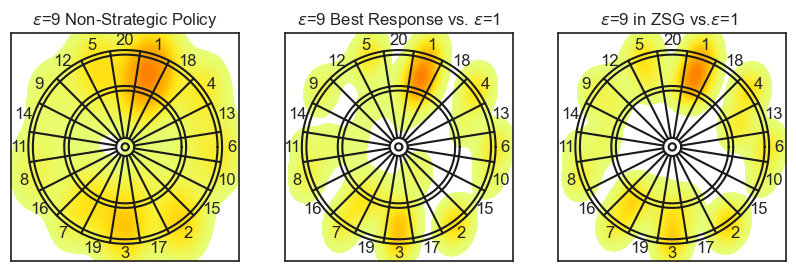

In [129]:
# Plot policy heatmaps

# Color parameters
cmap = 'Wistia'
alpha = 1
levels = 50

# Figure size
fig, ax = plt.subplots(1,3, figsize=(10,6))

# Plot three variations 
createKde(data=final_ns_policy_df, x='x', y='y', title=f"$\epsilon$={weaker_epsilon} Non-Strategic Policy", ax=ax[0], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=final_br_policy_df, x='x', y='y', title=f"$\epsilon$={weaker_epsilon} Best Response vs. $\epsilon$={stronger_epsilon}", ax=ax[1], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=final_zsg_policy_df, x='x', y='y', title=f"$\epsilon$={weaker_epsilon} in ZSG vs.$\epsilon$={stronger_epsilon}  ", ax=ax[2], cmap=cmap, levels=levels, alpha=alpha)